In [2]:
from __future__ import annotations
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterable
%matplotlib inline

# Backward propogation
Backward propogation involves calculating the gradients of a node with respect to the nodes that depend on it. This is possible through the chain rule. For example, if you had the equation `(4x + 10)^2`, you could decompose this into a series of function compositions: `(^2) . (+10) . (*4)`. You could then use the chain rule to calculate the derivative with respect to the node in front of it, and multiply that gradient by the other node's gradient to make sure the gradient is with respect to the final node.

# Activation functions
In neural networks, activation functions are generally used to normalize the value of a node to be within a certain range. The simplest of this is `tanh(x)`, which has a range between -1 and 1.

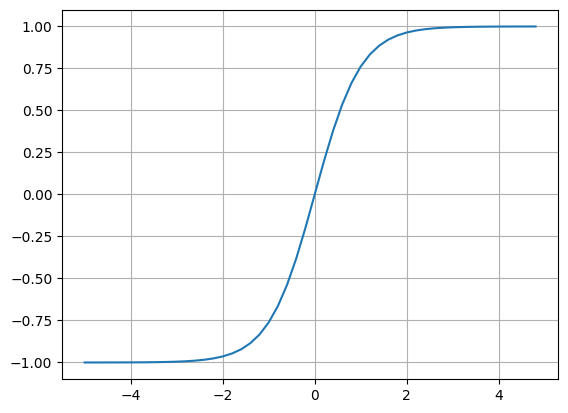

In [3]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

# Implementing Value.backward
The `Value.backward` needs to call the `_backward` method on all of its nodes, but it needs to do so in a order that keeps dependencies in mind. This can be done by topologically sorting nodes into an array where each node is guaranteed to come after all of the nodes that it depends on.

This means we will just be able to go through the topologically sorted list of nodes in reverse, and call `_backward` on all of them without any issues (assuming there are no circular dependencies).

In [4]:
class Value():
  def __init__(self,
               data: float,
               children: tuple[Value] = (),
               op: Optional[str] = None,
               label: Optional[str] = None):
    self.data = data
    self.grad = 0.0
    self._prev = set(children)
    self._backward = lambda: None
    self._op = op
    self.label = label
  
  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"
  
  def __add__(self, other):
    # The derivative of a function `(+c)`, where `c` is some constant should just be a copy of the
    # outer function's gradient. Let's say we had `(+5) . (*4)`. The gradient of `(*4)` would be
    # `4`, and that should be the gradient of `(+5) . (*4)` too.
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out
  
  def __mul__(self, other):
    # The gradient of a multiplication operation is just the value of the other multiplicand. If we
    # had `(x*y)`. The (partial) derivative of the expression with respect to `x` is just `y`, and
    # vice versa.
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __pow__(self, other):
    # The gradient of the exponentiation operation is a bit more complicated. Let's say we have the
    # expression `x^y`. The derivative with respect to x would just be `yx^(y-1)`, by the power
    # rule. The derivative with respect to `y` would be `ln(y) * x^y`. Note that by chain rule, we
    # need to get the gradient of `x`.
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data**other.data, (self, other), '**')

    def _backward():
      self.grad += other.data * (self.data ** (other.data - 1)) * out.grad
      other.grad += math.log(self.data) * self.data**other.data * self.grad * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def tanh(self):
    data = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)
    out = Value(data, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - out.data**2) * out.grad

    out._backward = _backward
    return out

  def relu(self, alpha):
    out = Value(math.max(alpha * self.data, self.data), (self, ), 'relu')

    def _backward():
      self.grad += (1 if self.data > 0 else alpha) * out.grad

    self._backward = _backward
    return out

  def sigmoid(self):
    out = Value(1 / (1 + math.exp(-self.data)), (self, ), 'sigmoid')

    def _backward():
      self.grad += out.data * (1 - out.data) * out.grad

    self._backward = _backward
    return out

  def exp(self):
    out = Value(math.exp(self.data), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    
    out._backward = _backward
    return out
  
  def backward(self):
    # Topologically sort nodes based on their dependencies
    topo = []
    visited = set()
    def visit(node):
      if node not in visited:
        visited.add(node)
        for child in node._prev:
          visit(child)
        topo.append(node)

    visit(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

For the sake of simplicity, I have been provided a `draw_dot` routine that draws out the graoh of values for me through graphviz.

In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# Example: A neuron
We will be following a simple architecture for a neuron: having two parameters (inputs), each having their own weights (constants). The parameters will be `x1` and `x2` and the weights for these parameters will be `w1` and `w2` respectively.

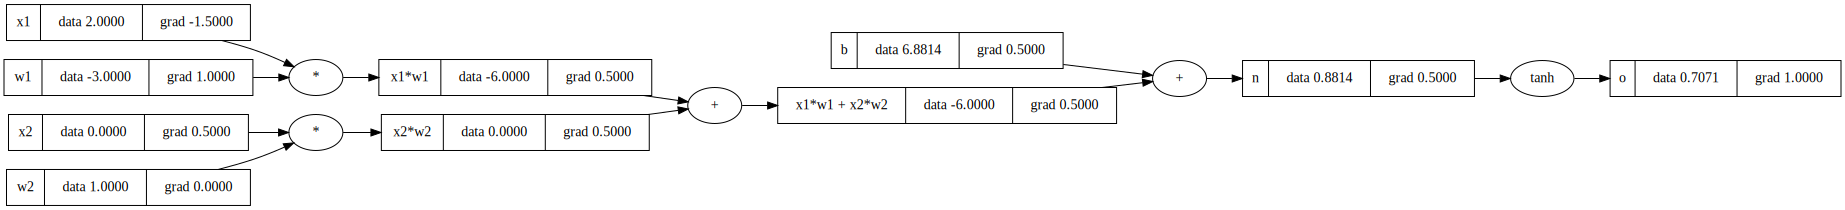

In [6]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

# Example: A more complicated neuron
This is a neuron, that follows no specific architecture, but makes use of a lot of features which is nice.

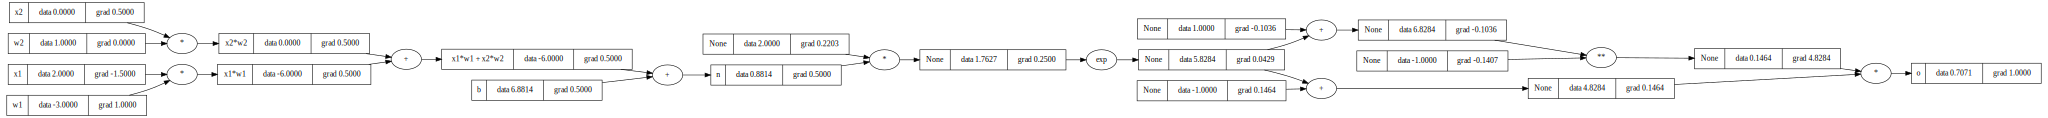

In [7]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'

o.backward()
draw_dot(o)

# Implementing a neural network
Now that we have a `Value` class and are able to do back-propogation, we can begin to implement a neural network. The most basic unit of a neural network is a neuron. A neuron takes an array of parameters, and multiplies each of them by their respective weight, and adds a bias to its output.

In [8]:
class Neuron:
  def __init__(self, ninput: float, act=lambda x: x.relu()):
    self.weights = [Value(random.uniform(-1, 1)) for _ in range(ninput)]
    self.bias = random.uniform(-1, 1)
    self.act = act

  def __call__(self, params: Iterable[float]):
    value = sum((wi * xi for xi, wi in zip(params, self.weights)), self.bias)
    return self.act(value)

  def parameters(self):
    return [self.bias] + self.weights

In [9]:
class Layer:
  def __init__(self, ninput: float, noutput: float):
    self.neurons = [Neuron(ninput) for _ in range(noutput)]

  def __call__(self, params: Iterable[float]):
    return [neuron(params) for neuron in self.neurons]

  def parameters(self):
    return [param for neuron in neurons for param in neuron.parameters()]

In [11]:
class MultilayerPerceptron:
  def __init__(self, ninput: float, noutput: float):
    size = [ninput] + noutput
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]
    
  def __call__(self, data: Iterable[float]):
    for layer in self.layers:
      data = layer(data)
    return data